# INEGIpy

INEGIpy es una librería para interactuar fácilmente con los datos del Instituto Nacinal de Geografía y Estadística (INEGI) desde Python. Su propósito es apoyar en la creación de consultas automatizadas y  en acceso a la información para el análisis de datos. 

De la información que ofrece el INEGI actualmente cuenta con un módulo dedicado al [Banco de Indicadores](https://www.inegi.org.mx/servicios/api_indicadores.html), otro dedicado al [DENUE](https://www.inegi.org.mx/servicios/api_denue.html) otro a la información del [Marco Geoestadístico](https://www.inegi.org.mx/servicios/catalogoUnico.html) y finalmente uno dedicado al [Sistema de Ruteo de México](https://www.inegi.org.mx/servicios/Ruteo/Default.html). 

También se encuentra en constrcción un módulo de Series dedicado a consultas automatizadas de los principales indicadores económicos como el PIB, INPC, Ocupación, etc. 

## Principales características

* Permite un acceso rápido a las bases de datos del INEGI sin necesidad de descargas.
* Regresa la información en DataFrames o GeoDataFrames listos para su uso en Python.
* Para el caso de los indicadores económicos, el DataFrame resultante cuenta con un DateTimeIndex y dos estilos de gráfica predeterminadios.
* Para las bases con información georeferenciada (DENUE, Marco Geoestadístico y Ruteo) se regresa un GeoDataFrame listo para realizar operaciones espaciales. 
    * El DENUE obtiene tanto la ubicción de los establecimientos como información sobre la actividad económica y el número de trabajadores.
    * El Marco Geoestadístico permite obtener la información de la población según el Censo de Viviendas del 2020 así como la información vectorial de las áreas que se especifiquen en cualquier nivel de agregación espacial. Evita descargar un montón de archivos Shape para realizar mapas y operaciones espaciales.
    * El Servicio de Ruteo además de calcular rutas entre puntos ofrece información georeferenciada sobre diferentes destinos los cuales pueden ser destinos turísticos o lugares de interés como aeropuertos, puertos, servicios médicos, o centros educativos de nivel superior. También ofrece detalles sobre el costo de las rutas y los precios promedio de los combustibles. 

## Requerimientos

* pandas
* matplotlib
* seaborn
* requests
* shapely
* geopandas
* fiona

La instalación de GeoPandas puede ser un poco complicada de manejar por lo que se recomieda [instalarla previemente](https://geopandas.org/en/stable/getting_started/install.html).


## Instalación

## Ejemplos de uso

### Indicadores 

In [19]:
from INEGIpy import Indicadores, PIB

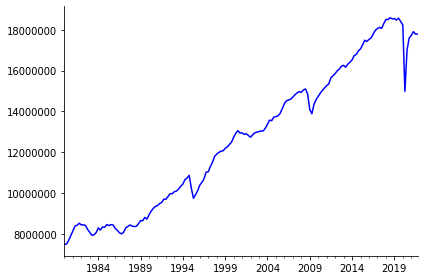

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [20]:
token = '92170321-528f-f1dd-5d59-f8613e072746'
pib = PIB(token)
pib.grafica()

### DENUE, Ruteo y MarcoGeoestadistico

#### Negocios a 5km de una coordenada

##### Distancia radial

In [1]:
from INEGIpy import DENUE, MarcoGeoestadistico
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import *
from geopy.geocoders import Nominatim
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
token = '92170321-528f-f1dd-5d59-f8613e072746'
denue = DENUE(token)
marco = MarcoGeoestadistico()

<AxesSubplot:>

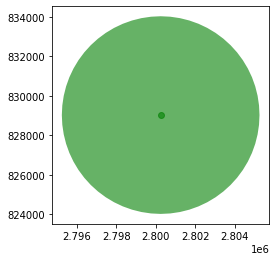

In [3]:
# construimos una capa para la zona a buscar
locator = Nominatim(user_agent='denue_app')
locator_resp = locator.geocode('Zócalo, Cuauhtémoc, Ciudad de México')
lat, lng = locator_resp.latitude, locator_resp.longitude
punto = Point(lng, lat)
zocalo = gpd.GeoDataFrame([punto], columns=['geometry'])
zocalo.crs = 'EPSG:4326' # como creamos la capa no tiene un CRS asociado
zocalo = zocalo.to_crs('EPSG:6372') # este crs nos permite realizar operaciones en metros en vez de grados en Ciudad de México
zocalo = pd.concat([zocalo, gpd.GeoDataFrame([zocalo.geometry.iloc[0].buffer(5000)], columns=['geometry'])], axis=0)
zocalo.plot(alpha=0.6, color='green')

<AxesSubplot:>

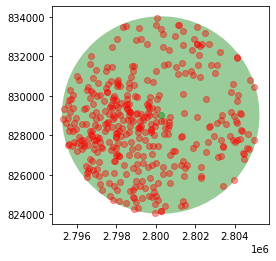

In [4]:
# utilizamos el DENUE para obtener una capa con los establecimientos en un radio de 5 km 
# inicié queriendo ver todos los establecimientos pero son demasiados para hacer buenos visuales así que acoté a solo los Oxxos
estabs = denue.Buscar('oxxo',lat,lng,5000)
estabs = estabs.to_crs('EPSG:6372') 

ax = zocalo.plot(alpha=0.4, color='green')
estabs.plot(ax=ax, alpha=0.4, color='red')

<AxesSubplot:>

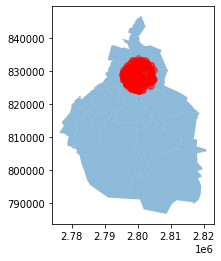

In [44]:
# utilizamos el marco geostadistico para obtener la capa del area geografica sobre la que plotear
# Si no conoces la clave de alguna entidad, municipio o localidad la puedes buscar por nombre en el marco geoestadístico

# regresa todas las manzanas en CDMX
muns = marco.Municipios(entidades='09')
muns = muns.to_crs('EPSG:6372')

ax = muns.plot(alpha = 0.5)
zocalo.plot(ax=ax, color='green', alpha=0.4)
estabs.plot(ax=ax, color='red', alpha=0.4)

<AxesSubplot:>

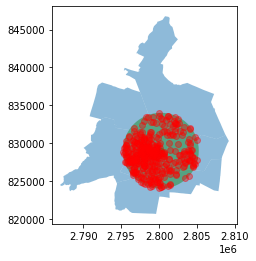

In [45]:
# reducimos a solo los municipios en el area

muns = muns[muns.geometry.intersects(zocalo.geometry.iloc[1])] # zocalo.geometry.iloc[1] es el buffer

ax = muns.plot(alpha = 0.5)
zocalo.plot(ax=ax, color='green', alpha=0.4)
estabs.plot(ax=ax, color='red', alpha=0.4)

In [5]:
# ya podemos hacer operaciones y obtener datos como las distancias al punto definido:

estabs['distancia_radial'] = estabs.geometry.distance(zocalo.geometry.iloc[0])
estabs.head()

,CLEE,Id,Nombre,Razon_social,Clase_actividad,Estrato,Tipo_vialidad,Calle,Num_Exterior,Num_Interior,...,Correo_e,Sitio_internet,Tipo,Longitud,Latitud,CentroComercial,TipoCentroComercial,NumLocal,geometry,distancia_radial
0,09015462112003412000008202S7,6316916,OXXO SUC 50WPJ PALMA MEX,CADENA COMERCIAL OXXO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,CALLE,PALMA,0,,...,ATENCIONCLIENTES@OXXO.COM,WWW.OXXO.COM,Fijo,-99.135259,19.432355,,,,POINT (2799948.266 829026.197),300.428750
1,09015462112001101000008202S8,6319281,OXXO SUC 50GBG PINO SUAREZ MEX,CADENA COMERCIAL OXXO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,AVENIDA,JOSÉ MARÍA PINO SUÁREZ,83,,...,ATENCIONCLIENTES@OXXO.COM,WWW.OXXO.COM,Fijo,-99.132410,19.429487,,,,POINT (2800252.890 828715.701),310.291630
2,09015462112005351000008202S5,6796478,OXXO SUC 50ICM TEMPLO MAYOR MEX,CADENA COMERCIAL OXXO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,CALLE,REPÚBLICA DE BRASIL,5,,...,ATENCIONCLIENTES@OXXO.COM,WWW.OXXO.COM,Fijo,-99.133952,19.435053,,,,POINT (2800079.152 829326.588),345.137576
3,09015462112005451000008202S3,6855065,OXXO SUC 50XMC REP URUGUAY II MEX,CADENA COMERCIAL OXXO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,CALLE,REPÚBLICA DE URUGUAY,131,,...,ATENCIONCLIENTES@OXXO.COM,WWW.OXXO.COM,Fijo,-99.130611,19.429574,,,,POINT (2800441.045 828729.057),353.769060
4,09015462112003842000008202S5,6316904,OXXO SUC 50YWD REP DEL SALVADOR MEX,CADENA COMERCIAL OXXO SA DE CV,Comercio al por menor en minisupers,6 a 10 personas,CALLE,REPÚBLICA DEL SALVADOR,96,,...,ATENCIONCLIENTES@OXXO.COM,WWW.OXXO.COM,Fijo,-99.134699,19.429397,,,,POINT (2800013.450 828700.903),401.254264


In [8]:
# podemos ver que la distancia mínima son 300 metros, la máxima es cercana a los 5 km y la media es de 3.1 km

estabs.distancia_radial.min(), estabs.distancia_radial.max(), estabs.distancia_radial.mean()

(300.4287498970337, 4978.781953233973, 3148.330243726626)

<AxesSubplot:>

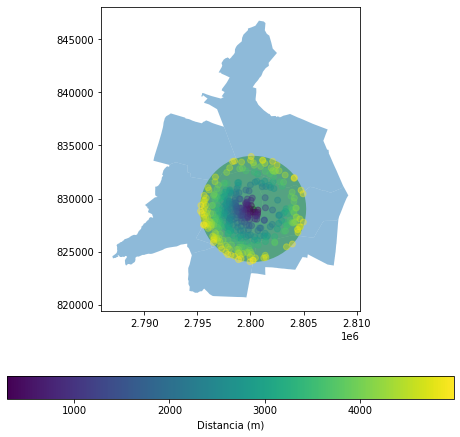

In [47]:
# podemos vizualizar la distriución espacial

#estabs['dist_discreta'] = round((estabs.distancia/1000))

ax = muns.plot(alpha = 0.5, figsize=(8,8))
zocalo.plot(ax=ax, color='green', alpha=0.4)
estabs.plot(ax=ax, alpha=0.4, column='distancia_radial', legend = True, legend_kwds={'label':'Distancia (m)','orientation':"horizontal"})

<AxesSubplot:>

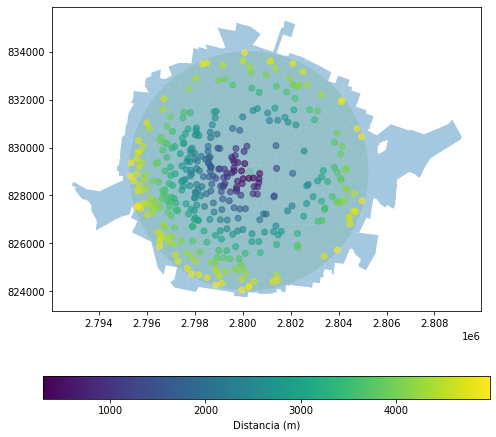

In [49]:
# podemos mejorar el mapa si usamos un nivel de agregación menor

agebs = marco.AGEBs(entidades = '09', municipios = muns.cve_agem.tolist())
agebs = agebs.to_crs('EPSG:6372')
agebs = agebs[agebs.geometry.intersects(zocalo.geometry.iloc[1])]

ax = agebs.plot(alpha = 0.4, figsize=(8,8), zorder=1)
zocalo.plot(ax=ax, color='green', alpha=0.1, zorder=2)
estabs.plot(ax=ax, alpha=0.6, column='distancia_radial',
            legend = True, legend_kwds={'label':'Distancia (m)','orientation':"horizontal"}, zorder=3)

<AxesSubplot:>

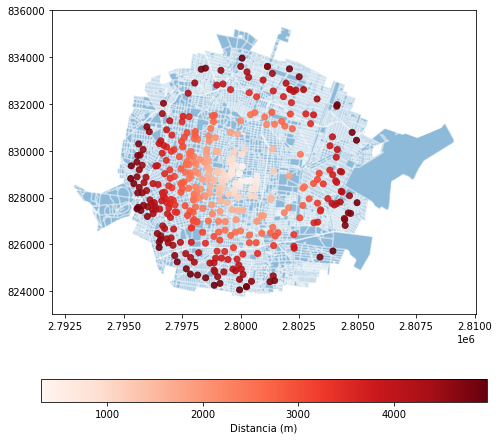

In [50]:
# para mejorar el mapa también podemos plotear las vialidades

vialidades = marco.Vialidades(entidades='09', municipios=muns.cve_agem.tolist())
vialidades = vialidades.to_crs('EPSG:6372')
agebs_dis = agebs.dissolve(by='cve_ent')
vialidades = vialidades[vialidades.geometry.intersects(agebs_dis.geometry.iloc[0])]

ax = agebs_dis.plot(alpha = 0.5, figsize=(8,8), zorder=1)
vialidades.plot(ax=ax, color='white', alpha=0.5, zorder=2)
#zocalo.plot(ax=ax, color='green', alpha=0.4, zorder=3)
estabs.plot(ax=ax, alpha=0.9, column='distancia_radial', cmap='Reds',
            legend = True, legend_kwds={'label':'Distancia (m)','orientation':"horizontal"},zorder=4)

##### Distancia en ruta

In [6]:
from INEGIpy import Ruteo

In [7]:
token_ruteo = 'UYH42si1-PMuQ-SDeD-DGWG-7Jiw2BCVoVQ5'
ruteo = Ruteo(token_ruteo)

In [8]:
# primero obtenemos la calle más cerca del punto inicial definido
# Para estopodemos usar la función BuscarLinea del módulo de ruteo

linea_i =  ruteo.BuscarLinea(lat, lng)
linea_i

,source,id_routing_net,nombre,target,geometry
0,642643,2962,Calle Plaza de la Constitución,769724,POINT (-99.13236 19.43230)


In [9]:
# Para calcular una ruta se requiere la utilizar la función BuscarLinea (o BuscarDestino dependiendo de lo que se busca) con el fin de obtener la línea final de la ruta
# Como tenemos varios puntos finales más bien sería una lista de líneas

# Noté que en ocasiones el Sistema de Ruteo no encuentra información para una coordenada si la escala no está correcta por lo que aumenté el valor default de 
# la escala a 1,000,000 lo cual resolvió el problema para las coordenadas resultantes del DENUE sin embargo es importante tenerlo en cuenta para otras bases. 

lineas_f = [ruteo.BuscarLinea(estabs.Latitud.iloc[i], estabs.Longitud.iloc[i]) for i in range(estabs.shape[0])]
len(lineas_f)

384

In [41]:
# una vez con las líneas resultantes de cada oxxo usamos la función CalcularRuta para obtener la rúta óptima desdse el punto inicial en el zócalo
# solo debemos darle como argumentos los DataFrames resultantes

# El INEGI no me ha respondido sobre límites o preferencias de uso pero noté que las primeras 280 rutas las calcula más rápido y a partir de ahí se alenta
# en lo que me responen estoy pausando cada 100 requests por si es una cuestión de límites aunque también puede ser que esas rutas tomen más tiempo por ser más largas
# el tiempo en el que corre la celda se acortó con el time.sleep(30) así que sí puede ser una cuesstión de límites
import time

rutas = []
for j in range(len(lineas_f)):
    r = ruteo.CalcularRuta(linea_i, lineas_f[j])
    rutas.append(r)
    if j%100 == 0: time.sleep(30)
    
len(rutas)

384

In [42]:
rutas = gpd.GeoDataFrame(pd.concat(rutas,axis=0).reset_index(drop=True))
rutas.head()

,costo_caseta,tiempo_min,advertencia,long_km,peaje,geometry
0,0.0,0.87,,0.58,f,"MULTILINESTRING ((-99.13422 19.43216, -99.1343..."
1,0.0,1.63,,1.31,f,"MULTILINESTRING ((-99.13236 19.43078, -99.1330..."
2,0.0,0.71,,0.50,f,"MULTILINESTRING ((-99.13404 19.43397, -99.1340..."
3,0.0,2.27,,1.56,f,"MULTILINESTRING ((-99.13236 19.43078, -99.1314..."
4,0.0,0.87,,0.58,f,"MULTILINESTRING ((-99.13422 19.43216, -99.1343..."


In [55]:
# con las rutas ya podemos tener la distancia y clasificar así los puntos
# la columna long_km y el length que calcula Shapely difiere por metros, ambos son de fácil acceso así que cualquiera se puede usar

estabs['distancia_ruta'] = rutas.long_km

<AxesSubplot:>

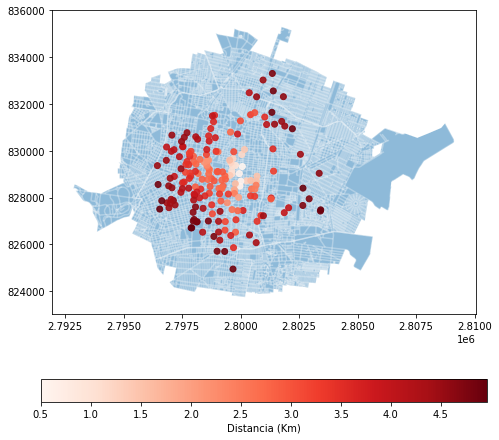

In [89]:
# Finalmente podemos visualizar los oxxos que se encuentran a 5 km en ruta 

ax = agebs_dis.plot(alpha = 0.5, figsize=(8,8), zorder=1)
vialidades.plot(ax=ax, color='white', alpha=0.3, zorder=2)
#zocalo.plot(ax=ax, color='green', alpha=0.4, zorder=3)
estabs[estabs.distancia_ruta <= 5].plot(ax=ax, alpha=0.9, column='distancia_ruta', cmap='Reds',
            legend = True, legend_kwds={'label':'Distancia (Km)','orientation':"horizontal"},zorder=4)